# Dimensionality reduction

In this first tutorial we are going to explore some clustering algorithms on the `iris` dataset, which contains 5 features (sepal length, sepal width, petal length, petal width, and species). To do that, we will use the popular `sklearn` Python library. Let's start by loading the data in our environment. `sklearn` is shipped with the `iris` dataset, so we can easily just call the related function. In addition, we use the `polars` library to handle our data as a dataframe for fast queries.

In [1]:
from sklearn.datasets import load_iris
import polars as pl

# load iris dataset
iris = load_iris(as_frame=True)

# assign target values to actual target species names
iris.frame["target"] = iris.target_names[iris.target]

# build polars dataframe
iris = pl.DataFrame(iris.frame)

# show first 10 rows
iris.head(10)

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""setosa"""
4.9,3.0,1.4,0.2,"""setosa"""
4.7,3.2,1.3,0.2,"""setosa"""
4.6,3.1,1.5,0.2,"""setosa"""
5.0,3.6,1.4,0.2,"""setosa"""
5.4,3.9,1.7,0.4,"""setosa"""
4.6,3.4,1.4,0.3,"""setosa"""
5.0,3.4,1.5,0.2,"""setosa"""
4.4,2.9,1.4,0.2,"""setosa"""


We can now extract some features of interest and explore a bit more what the data looks like. For instance, let's say we are interested in getting the mean value of each feature per species. Let's say we are also interested in knowing the max value of sepal length and the minimum value of sepal width. To achieve this, we can use the powerful `polars` queries.

In [2]:
# mean per species
mean_by_spp = iris.group_by("target").mean()
print(mean_by_spp)

# multiple queries per single group_by operation
summaries = iris.group_by("target").agg([
    pl.col("sepal length (cm)").max().alias("max sepal length (cm)"),
    pl.col('sepal width (cm)').min().alias('max sepal width (cm)')])
print(summaries)

shape: (3, 5)
┌────────────┬───────────────────┬──────────────────┬───────────────────┬──────────────────┐
│ target     ┆ sepal length (cm) ┆ sepal width (cm) ┆ petal length (cm) ┆ petal width (cm) │
│ ---        ┆ ---               ┆ ---              ┆ ---               ┆ ---              │
│ str        ┆ f64               ┆ f64              ┆ f64               ┆ f64              │
╞════════════╪═══════════════════╪══════════════════╪═══════════════════╪══════════════════╡
│ virginica  ┆ 6.588             ┆ 2.974            ┆ 5.552             ┆ 2.026            │
│ versicolor ┆ 5.936             ┆ 2.77             ┆ 4.26              ┆ 1.326            │
│ setosa     ┆ 5.006             ┆ 3.428            ┆ 1.462             ┆ 0.246            │
└────────────┴───────────────────┴──────────────────┴───────────────────┴──────────────────┘
shape: (3, 3)
┌────────────┬───────────────────────┬──────────────────────┐
│ target     ┆ max sepal length (cm) ┆ max sepal width (cm) │
│ ---      

For more advanced computations on large dataframes, it is recommended to use the `polars` lazy API, which is natively multithreaded and optimized in the background for faster operations. For example, we can calculate the approximate area of each petal, pretending they look like triangles. Note that our current dataframe consists only of 150 observations, so there is no real benefit of using the lazy API.

In [3]:
lazy_area = iris.lazy().with_columns(
    (pl.col("petal length (cm)") * pl.col("petal width (cm)") / 2).alias("petal area (cm2)")
)

# explore the computation tree in the background
print(lazy_area.explain(optimized=True))

 WITH_COLUMNS:
 [[([(col("petal length (cm)")) * (col("petal width (cm)"))]) / (2.0)].alias("petal area (cm2)")] 
  DF ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)", ...]; PROJECT */5 COLUMNS


Now that we have explored a bit our data, it seems easier to visualize the relationships among variables. Earlier we saw one way to do this: plot each variable again the other. However, this may not work when our data consists of many features (high dimensional space). One way to deal with this is by reducing the dimensionality of the data. The most common and easy approach to do dimensionality reduction is via a **Principal Component Analysis**. `sklearn` provides an intuitive API to achive this.

We will reduce the 4 dimensions of our data down to 3, so that we can better explore the relationship among variables in a 3D space. In addition, we can retrieve the names of the features that went in the PCA, so that we can use there 3 features, for example, as uncorrelated model variables.

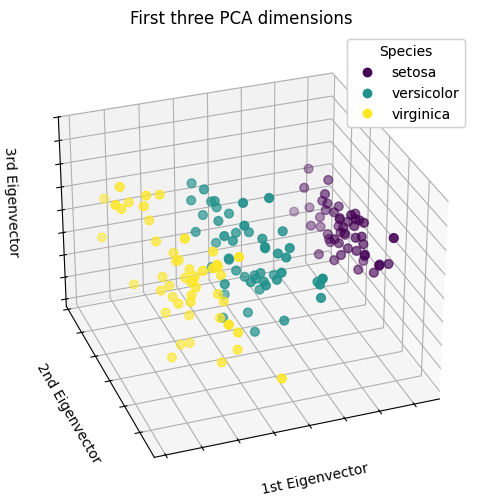


Explained variance by component (%): [92.46187232  5.30664831  1.71026098]

Feature names matching components: petal length (cm), sepal length (cm), petal width (cm)


In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# initialize PCA object
pca = PCA(n_components=3)

# run PCA on all column but "target"
spp = iris["target"]
iris = iris.drop("target")
iris_reduced = pca.fit_transform(iris)

# prepare for plotting: assign an integer to each character target value
spp = spp.to_frame().with_columns(
    colors=pl.col("target").replace_strict(["setosa", "versicolor", "virginica"], [1, 2, 3])
)

# plot the result (make a function to use later)
def plot_me(data, **kwargs):
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
    scatter = ax.scatter(
        data[:, 0],
        data[:, 1],
        data[:, 2],
        c=kwargs.get("colors"),
        s=40,
    )
    ax.set(
        title="First three PCA dimensions",
        xlabel="1st Eigenvector",
        ylabel="2nd Eigenvector",
        zlabel="3rd Eigenvector",
    )
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    # add legend
    legend1 = ax.legend(
        scatter.legend_elements()[0],
        np.unique(kwargs.get("legend")),
        loc="upper right",
        title=kwargs.get("legend_title"),
    )
    ax.add_artist(legend1)

    plt.show()

plot_args = {
    "colors": spp["colors"],
    "legend": spp["target"],
    "legend_title": "Species"
}
plot_me(iris_reduced, **plot_args)

# explained variance
print(f"\nExplained variance by component (%): {pca.explained_variance_ratio_ * 100}\n")

# get components
coords = pca.components_

# get largest 3 values for first component, explaining ~92% of the variance
ind = coords[0].argsort()[-3:][::-1]

# corresponding colum names
print(f"Feature names matching components: {', '.join([iris.columns[i] for i in ind])}")

# Clustering
## KMeans

Great! So far we explored some data dimensionality reduction routines. It is time to dive deeper into other unsupervised learning tools. With clustering techniques, we try to understand unseen relationships within the data. This process sometimes can be persived as more "subjective" than supervised approached, simply because the relationships between input and output values have not been stated. Therefore, the final result we will obtain is a function of the algorithm we will use in our data exploration quest.

In general, when dealing with different units of measurement or highly dimensional data, it is good practice to scale your data before clustering. For example, consider that your dataset is composed of a variety of units and ranges (e.g. areas, volumes, counts, costs, etc.). In this scenario, scaling your data beforehand is almost necessary because clustering algorithms work by measuring similarities or distances. Therefore, one feature may dominate the other simply because it may have a larger interquartile range.

One of the most basic and simple clustering algorithms you will encounter is K-Means. K-Means is a data partitioning algorithm that finds the best boundaries in a high dimensional data space such that the centroids of data "clusters" are the farthest apart from each other (i.e. the most disinguishable). Let's try it!

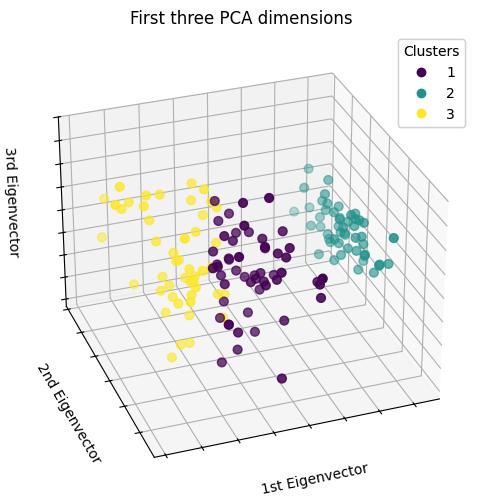

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# initialize kmeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# initialize processing pipeline: first scale then kmeans
pipeline = make_pipeline(StandardScaler(), kmeans)

# get cluster labels (iris here has only 4 features)
labels = pipeline.fit_predict(iris)

# plot the result
plot_args = {
    "colors": labels,
    "legend": ["1", "2", "3"],
    "legend_title": "Clusters"
}
plot_me(iris_reduced, **plot_args)

You may see that the clusters that we identified via KMeans are pretty well-structured, however there is some confusion when compared to the actual data. In this case we don't need to adjust the number of clusters, nor identify the best number because we already know about the output labels. Let's now work with a different dataset where we have no prior knowledge of how the data shoule be categoried.

## Hierarchical clustering

Raster data is a multidimensional tensor. In the case of multidimensional or multiband raster data, think of it as a stack of flat grids (rows, columns) where each grid represents a property of interest, like in the image below. The horizontal axis represents the X coordinate (longitude), the vertical axis represents the Y (latitude), while the Z axis repesents a series of properties of interest (e.g. tree height, volume, biomass, etc.). Raster data introduce an additional level of complexity, that is spatial information associated with each observation (pixel).

![Raster stack](/mnt/sda1/EDI-HPC/python/img/cube.png)

Let's try to apply the same logic we saw earlier to classify a multiband raster. We are going to use a different family of clustering algorithms that partition the data by iteratively agglomerating observations into larger or smaller clusters. In this scenario, we don't have to set a number of clusters a priori, we first build a hierarchical agglomerative structure, and later we decide where to prune it.

Our first pick is a traditional **Hierarchial Clustering (HC)** technique. We start by identifiying relationships among observations based on distances, which will be used to build a linkage tree (dendrogram) that dictates how observations relate to each other. Pretty much like a lineage tree. Here, we could also use the simple `sklearn` syntax if we knew the number of clusters a priori (or have a sense of how many clusters there could be). If we want more control over the linkage tree, we need to rely on `scipy`.

In this example we are working with a Landsat 7 scene at 30 m resolution with 6 bands and some noise.

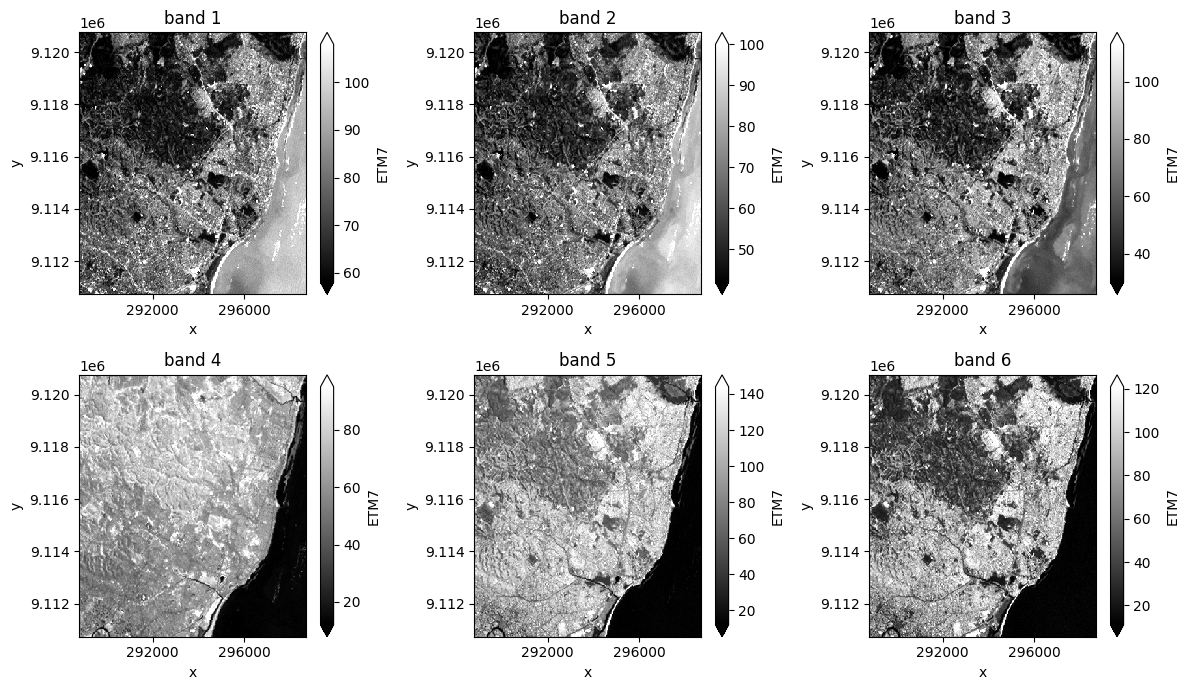

In [6]:
import rioxarray as rxr
import matplotlib.pyplot as plt

# import dataset and plot it
with rxr.open_rasterio("data/raster.tif") as src:
    src.name = "ETM7"
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
    axs = axs.flatten()
    for i, (ax, band) in enumerate(zip(axs, src)):
        # find tails of the distribution
        vmin, vmax = np.percentile(band, [2, 98])
        # plot with enhances contrast
        band.plot(ax=ax, cmap="gray", vmin=vmin, vmax=vmax)
        ax.set_title(f"band {i + 1}")
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    plt.tight_layout()
    plt.show()

To be able to cluster the data, we need to build a dataframe with shape `(n_sample, n_features)` while keeping track of where each observation is located on the image. In the case of missing data or noise in the image, those pixels can (and should) be filtered out when applicable. Some ML tools can't deal well with missing data. If that's the case, you need to keep track of where the missing values are, so when you re-build your image, you don't move the pixels around. Alternative, if applicable, you can impute or interpolate the missing values.

Note that in this case we downsample the image to reduce the volume of data to compute. If you want to process the entire six bands in memory at the original resolution and a `float64` dtype, you'd need ~60 GB of RAM.

In [7]:
# resample to be 150 m spatial resolution
downscale_factor = 5
new_width = src.rio.width // downscale_factor
new_height = src.rio.height // downscale_factor

resampled = src.rio.reproject(
    src.rio.crs,
    shape=(new_height, new_width)
)

Now we can run the actual clustering. Given we are working with a real Landsat scene, it is not unreasonable to expect some noise, so we'll rely on a more robust scaler to account for outliers.

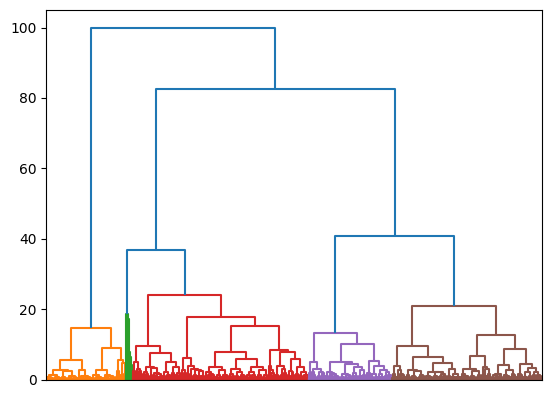

In [8]:
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# reshape to columnar values
stack = resampled.stack(z=["y", "x"]).transpose()

# scale refelctance values
scaled = RobustScaler().fit_transform(stack.data)

# convert to dataframe
df = pl.from_numpy(scaled)
df.columns = [f"band{i}" for i in range(1, len(resampled) + 1)]

# compute pairwise distances for each observation
pair_dist = pdist(df)

# build linkage tree
linked = linkage(pair_dist, method="ward")

# normalize distances
linked[:, 2] = ((linked[:, 2] - np.min(linked[:, 2])) /
                (np.max(linked[:, 2]) - np.min(linked[:, 2])) * 100)

# plot dendrogram with arbitrary threshold (for coloring purposes only)
dendro = dendrogram(linked, color_threshold=30, no_labels=True)
plt.show()

Well...it's very dense at the bottom where each observation represents a single cluster. So, how many clusters do we select given this dendrogram? We can arbitrarily define a distance cutoff and set the number of clusters accordingly. For example, if we decide to prune the dendrogram at an arbitrary cutoff distance of 20 or 40 (normalized), we would end up with 7 or 4 clusters, respectively. Very different numbers! A simple way to get the number of clusters from the dendrogram is presented below.

In [9]:
def get_clusters_number(height, z):
    n_leaves = z.shape[0] + 1
    merge_heights = z[:, 2]
    n_clusters = n_leaves - np.digitize(height, merge_heights)
    return n_clusters

# test with distances 20 and 30
height = [20, 40]
n_clusters = [get_clusters_number(th, linked) for th in height]
for n, h in zip(n_clusters, height):
    print(f"Clusters for distance {h}: {n}")

Clusters for distance 20: 7
Clusters for distance 40: 4


But which number of clusters is the "right" one? Difficult to say, but we can leverage some tools that give us clues on which number is best, from a statistical point of view. One such tool that is common to use are `silhouette scores`. The score has range `(-1; 1)`, where -1 indicates values wrongly assigned to a cluster, 0 indicates overalpping clusters, and 1 is the best match for a specific observation. Let's try it our using `sklearn`.

In [10]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm

# list likely number of clusters
range_clusters = range(3, 15)

# iteratively clusterize the data and compute the score
best = []
for n_clusters in tqdm(range_clusters):
    # form clusters
    hc_labels = fcluster(linked, t=n_clusters, criterion='maxclust')

    # get average silhouette score for all samples
    silhouette_avg = silhouette_score(df, hc_labels)
    best.append(silhouette_avg)
    print(f"Average silhouette score for {n_clusters} clusters: {silhouette_avg}")

print(f"\nBest number of clusters: {range_clusters[best.index(max(best))]}")

  0%|          | 0/12 [00:00<?, ?it/s]

Average silhouette score for 3 clusters: 0.46658840775489807
Average silhouette score for 4 clusters: 0.3692489564418793
Average silhouette score for 5 clusters: 0.39020681381225586
Average silhouette score for 6 clusters: 0.35486412048339844
Average silhouette score for 7 clusters: 0.31440314650535583
Average silhouette score for 8 clusters: 0.31582191586494446
Average silhouette score for 9 clusters: 0.3192821741104126
Average silhouette score for 10 clusters: 0.32220789790153503
Average silhouette score for 11 clusters: 0.32106998562812805
Average silhouette score for 12 clusters: 0.2728182375431061
Average silhouette score for 13 clusters: 0.265342652797699
Average silhouette score for 14 clusters: 0.2604616582393646

Best number of clusters: 3


There we go! The best number of clusters for this data seems to be three! Let's plot the per-sample silhouette score and see what this acutally looks like. After that, we can finally apply the labels to the Landsat scene.

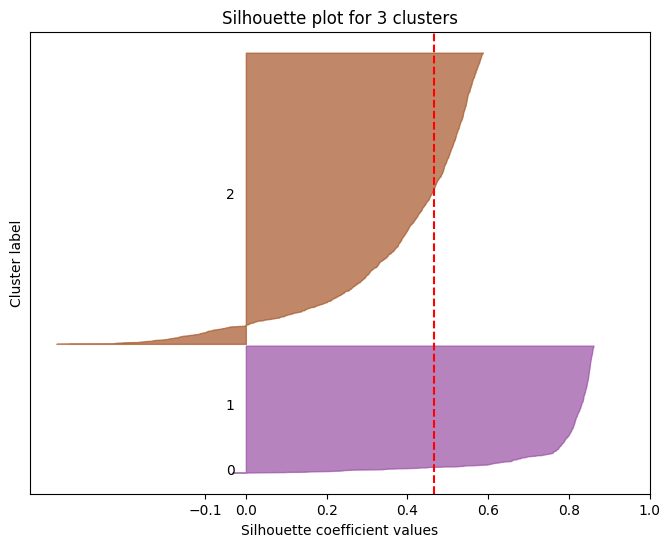

In [11]:
import matplotlib.cm as cm

# plot silhouette profile
n_clusters = 3
hc_labels = fcluster(linked, t=n_clusters, criterion='maxclust')
silhouette_avg = silhouette_score(df, hc_labels)
silhouette_values = silhouette_samples(df, hc_labels)

fig, ax = plt.subplots(figsize=(8, 6))

# aggregate the silhouette scores for samples and sort them
y_lower = 10
for i in range(n_clusters):
    # aggregate the silhouette scores for samples belonging to each cluster, and sort them
    ith_cluster_silhouette_values = silhouette_values[hc_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Set1(float(i) / n_clusters)
    ax.fill_betweenx(
       np.arange(y_lower, y_upper),
       0,
       ith_cluster_silhouette_values,
       facecolor=color,
       edgecolor=color,
       alpha=0.7,
    )

    # add labels
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # compute the new y_lower for next plot
    y_lower = y_upper + 10

ax.set_title(f"Silhouette plot for {n_clusters} clusters")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# set vertical line for average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

As you can see, there has been some misplacement of points into the clusters. This is pretty normal. You should also consider that the lower the number of clusters, likely the higher the silhouette score. With only two clusters, the score would be even higher. That's where some subjectivity may come into play. Are two or three clusters really meaningful? Or would we expoect more variability in the Landsat scene?

Let's try and plot it with a more "reasonable" number of clusters (five).

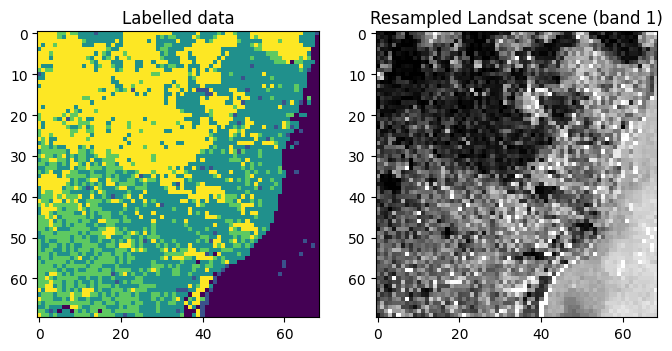

In [12]:
# replace the Landsat values with the cluster labels (5 clusters)
hc_labels = fcluster(linked, t=5, criterion='maxclust')

# reshape the labels to match the shape of the scene
labelled = hc_labels.reshape(resampled.shape[1], resampled.shape[2])

# plot
fig, ax = plt.subplots(figsize=(8, 12), nrows=1, ncols=2)
ax[0].imshow(labelled)
ax[0].set_title("Labelled data")
ax[1].imshow(
    resampled.data[0],
    cmap="gray",
    vmin=np.percentile(resampled[0], 2),
    vmax=np.percentile(resampled[0], 98)
)
ax[1].set_title("Resampled Landsat scene (band 1)")
plt.show()

## Density-based algorithms

In addition, we can briefly explore another popular clustering technique called <ins>D</ins>ensity-<ins>B</ins>ased <ins>S</ins>patial <ins>C</ins>lustering of <ins>A</ins>pplications with <ins>N</ins>oise **DBSCAN** and its <ins>H</ins>ierarchical counterpart **HDBSCAN**. They work in a similar fashion as **HC**, yet (H)DBSCAN is density-aware, so it can better detect agglomerations of data points in a hyperdimensional feature space while compensating for the intrusion of noise. Note, however, that with greater potential comes greater responsabilities. (H)DBSCAN requires finer parameter tuning than other clustering algorithms we saw, so considerations must be made on how to appropriately select the clustering parameters. In this brief example, we'll use the default values. Moreover, with (H)DBSCAN we can't control the number of clusters, rather we have to tweak the clustering parameters according to the data we have.

These clustering algorithms are powerful in that they can give additional information related to the shape and branching of each cluster. Therefore, it's very good for data exploration and to understand the evolution of a process.

DBSCAN is available from `sklearn`, while HDBSCAN can be used with the `hdbscan` package, installable with `pip`, `conda`, or similar alternatives. HDBSCAN is also available in `sklearn`, however `hdbscan` offers more control and produces better results with default parameters than the `sklearn` version.

Let's try it on our Landsat scene.

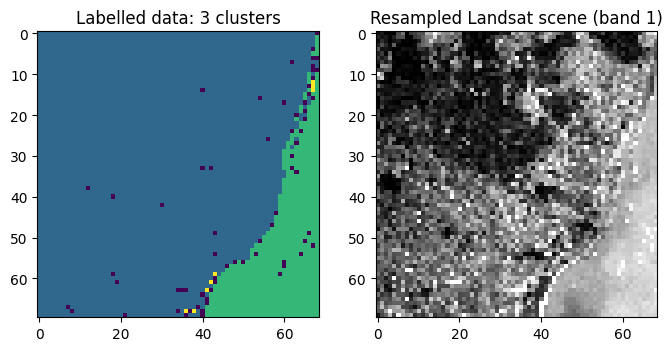

In [13]:
import warnings
from hdbscan import HDBSCAN

# initialize clusterer with defaul parameters and fit to the data
with warnings.catch_warnings():  # suppress FutureWarning
    warnings.filterwarnings("ignore")
    clusterer = HDBSCAN().fit(df)

# get labels
labels = clusterer.labels_
labels = labels.reshape(resampled.shape[1], resampled.shape[2])
n_clusters = np.unique(labels)
n_clusters = n_clusters[n_clusters >= 0]  # HDBSCAN returns -1 for noise points

# plot
fig, ax = plt.subplots(figsize=(8, 12), nrows=1, ncols=2)
ax[0].imshow(labels)
ax[0].set_title(f"Labelled data: {len(n_clusters)} clusters")
ax[1].imshow(
    resampled.data[0],
    cmap="gray",
    vmin=np.percentile(resampled[0], 2),
    vmax=np.percentile(resampled[0], 98)
)
ax[1].set_title("Resampled Landsat scene (band 1)")
plt.show()


We ended up with three clusters given the default parameters. While this is a robust way to build density- and noise-aware clusters, it comes with the cost of tuning the clustering parameters and a generally higher computational demand for large datasets.

## LiDAR
Light Detection and Ranging (LiDAR) is a revolutionary technology that informs on the teh 3D properties of the environment. It adds a complexity level because we now have to introduce a third dimension in our data. From 2D or multi-band rasters, we now deal with 3D coordinates. However, it is common to extrapolate metrics from LiDAR data such that we would still end up with a multi-band raster, each representing a specific LiDAR metric of interest. For example, we can extract max point height within a 30 x 30 m region to match the values from the Landsat scene we worked with earlier on. Alternatively, you can directly work at the point cloud level by treating each coordinate and its relationships with other coordinates as features. Therefore, we can apply a HDBSCAN algorithm to individual trees to delineate branches, or we can separate land types (e.g. treed / non-treed) based on derived height.

Let's try to delineate the branches of a tree using the default parameters of HDBSCAN and see how it performs. To do that, we load the data in, plot it, and use some tuned HBSCAN parameters to label the points. To work with LiDAR data, you need to have `laspy` installed. This package allows you to read and write point cloud data in the LAS/LAZ format, while the manipulation of the data itself is up to you and your coding skills.

In this example, we are going to use the [FOR-species20K dataset](https://github.com/stefp/FOR-species20K.git) as an example of open-access dataset of labelled tree species at various point densities accessible from Zenodo at [this](https://doi.org/10.5281/zenodo.13255197) link. We are going to work with a single tree and only focus on the x-y-z coordinates for speed.

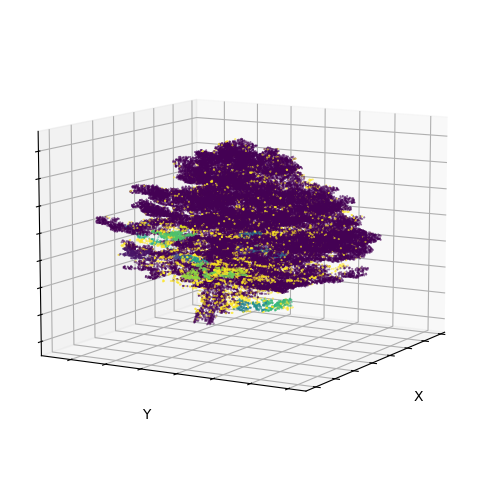

In [20]:
import laspy

# read in
laz = laspy.read('data/06847.laz')

# plot it
def plot_laz(coords, colors=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=10, azim=-150)
    scatter = ax.scatter(
        coords[:, 0],
        coords[:, 1],
        coords[:, 2],
        c=colors,
        cmap="viridis_r",
        s=0.2)
    ax.set(
        xlabel="X",
        ylabel="Y",
        zlabel="Z",
    )
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    plt.show()

# run HDBSCAN on the coordinates
with warnings.catch_warnings():  # suppress FutureWarning
    warnings.filterwarnings("ignore")
    pc_clusterer = HDBSCAN(
        min_cluster_size=50,  # points
        min_samples=5, # points
        cluster_selection_epsilon_max=0.2,
    ).fit(laz.xyz)

# get number of clusters
labels = pc_clusterer.labels_
n_clusters = np.unique(labels)
n_clusters = n_clusters[n_clusters >= 0]

# plot colors by cluster
plot_laz(laz.xyz, labels)

While this clustering was far from perfect, you'd need to spend more time tuning the clustering parameters or pivot towards more suited algorithms. For other cool applications for LiDAR point cloud data, join our next workshop on **Match 24th**!